# Basics of `xarray`

One of the strengths of Python (and why I'm starting to tolerate its shortcomings) is the ability to manipulate large multidimensional datasets, especially through the `xarray` library.  You can read more about some of [the advantages of `xarray` here](https://docs.xarray.dev/en/stable/getting-started-guide/why-xarray.html).  For those of us in the climate field, much of our data (both observations and modeling) will come in a form that can be readily read, organized, and manipulated by `xarray`.  It also has immediate application to remote sensing, including packages that extend `xarray` for multispectral application and other types of spatial analysis, beyond what we'll learn in this class.  For those of you who have datasets more ameniable to Pandas, the two packages are well-coordinated, and it is easy to use Pandas-type data and functionality with xarray, and vice versa.  

Let's learn some of the basic functionality of xarray.  As we go along, and as we encounter new types of data and new types of analytical problems or computational tasks, we'll continue to add to our familiarity with this library.  For now, we'll focus on the type of use example that you can apply in your next homework as well as some fundamentals.

As always, let's start by importing the key packages.  We will import xarray as `xr` following conventions.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# you can omit the line below if you'd like, but I really don't like the default fonts in Python, so I switch to Helvetica
plt.rcParams['font.family'] = 'Helvetica'

# lastly, let's get xarray as xr, following standard conventions
import xarray as xr


Xarray has a flexible module for bringing datasets into your workspace.  [`.open_dataset`](https://docs.xarray.dev/en/stable/generated/xarray.open_dataset.html) is designed to open a variety of file formats in the netCDF format (Network Common Data Form), data formats ['that support the creation, access, and sharing of array-oriented scientific data'](https://www.unidata.ucar.edu/software/netcdf/).  It is a very common format for climate observations and simulations.  Since our first exercise will use climate observations, we'll focus on it here.

xarray is based around two new types of data structures - the `DataArray`` is [a wrapper around numpy nd-arrays that uses labeled dimensions and coordinates](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html).  The DataSet is similar to the Panda's DataFrame, and is ['a multi-dimensional array database'](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) -- e.g. it can hold multiple variables with coordinates and metadata that allow you to operate on them.

xarray provides the following visualization:

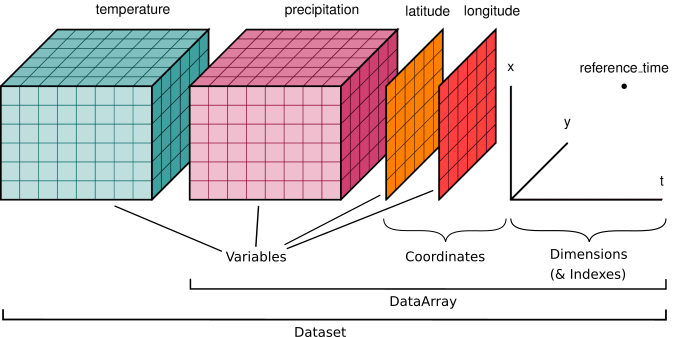

So a `DataSet` could hold multiple climate variables, for instance, with a `DataArray` being one of those variables with its coordinate systems (latitude, longitude, time, depth, height, etc. etc.)

xarray makes it super easy to read in a netcdf dataset and place it in a `DataSet`, just using `xr.open_dataset`.  Here we'll read in the gridded dataset of monthly sea surface temperatures (SST) from the Hadley Centre in the UK.  You can [get the netcdf here (warning, large file!)](https://www.metoffice.gov.uk/hadobs/hadisst/data/HadISST_sst.nc.gz) to use in this exercise or download it from the course D2L. 

In [ ]:
ds = xr.open_dataset('HadISST_sst.nc') 
ds

Having done this, we see that `ds` is a DataSet type.  There is information on the dimensions of the dataset, there are two data variables: sea surface temperature and time_bnds (we'll ignore that second one), there is a a set of coordinates (latitude, longitude, and time) which are also indices (in the Pythonic sense), and attributes that come from the metadata of the netcdf file.   Notice the time dimension is a `datetime` type, which means that Python recognizes it as not just numbers, but numbers representing years, months, days, hours, etc. etc.  This is similar to Pandas. 

There are various options that can be called with `xr.open_dataset` that might be of interest: `mask_and_scale=True` uses the metadata to do any scaling to the data (sometimes, data are scaled for compression purposes) and replaces missing value with NaN.  For climate data, `use_cftime=True` and ` decode_cf=True` allow you to use [CF conventions](https://cfconventions.org/) for data properties, if they were used by the file creator.

We can operate directly on the DataSet, but we can also pull out individual variables into DataArrays.  One of the features of xarray is that the coordinate system and information from the DataSet travels with the DataArray variables.  So, for instance, we could extract just the `sst` variable from the DataSet, as well as latitude and longitude:

In [ ]:
sst = ds.sst
lat = ds.latitude
lon = ds.longitude
sst


We can see that the variable `sst` is now a DataArray, but it carries with it the coordinate information from the DataSet. If we look at `lat` we see that is is also a DataArray, but xarray knows it is 'just' a coordinate, not a data variable, and labels it accordingly:

In [ ]:
lat

Let's learn a little about xarray's many functionalities.  Right off the back you might spot something odd about the SST data we've read into the workspace.  We can ask xarray to tell us the maximum and minimum SST values in the data variable:

In [ ]:
print(sst.max())
print(sst.min())

Uh, the maximum looks reasonable (35C or about 95F, not unreasonable for SSTs in the high sun season in some shallow tropical regions), but the minimum is -1000C ... so, surface water that is 1000 degrees below freezing.  Seems unlikely, right? 

It turns out that this dataset uses '-1000' to indicate an ocean location where it doesn't have SST data (usually associated with regions of sea ice).  The metadata in the netcdf file _should_ contain this information, but it turns out it has the wrong value in the metadata:

In [ ]:
sst.encoding['missing_value']


Who, that's a large negative number - it should be -1e+3 (-1 times 10 to the 3rd power), which is -1000.

Never fear, though, we can use the xarray `.where` to fill the very negative numbers with NaN values.  [`.where` returns elements of the DataArray that meet some condition](https://docs.xarray.dev/en/stable/generated/xarray.where.html).  In this case, we'll ask xarray to only return the values where SSTs are higher than 0C, place NaN (really, `np.nan`) where the condition is false, and then overwrite SST:

In [ ]:
sst = sst.where(sst>=0,np.nan)
print(sst.max())
print(sst.min())


That's better!  Let's see what else we can do. 

We can see the coordinate dimensions of our data using `.dims`:

In [ ]:
sst.dims

Alternatively, `.coords` gives us a bit more information, with not only the names but the data types and a peak at the first and last entries in each coordinate system.  Here we can see we've got time at monthly steps starting from January 1870 through early 2023, latitude from -89.5 to 89.5, and longitude from -179.5 to 179.5, with both latitude and longitude on 1.0 degree steps.:

In [ ]:
sst.coords

In a similar manner to NumPy and Pandas, we can extract named components of the DataSet or DataArray, because the coordinates are attached to the data variables:

In [ ]:
sst["longitude"]

You can also see the attributes are attached to the variable as well:

In [ ]:
sst.attrs

Similar to Pandas, we have a range of ways we can select, slice, and subset our data.   For instance, we can use `.sel` to select specific times or locations in our dataset:

In [ ]:
sst.sel(time='1878-12')

The coordinates in the DataSet or DataArray function as a dictionary, in Python terms, so we can access the data variable through specific calls using the named coordinates and directly requesting a datetime, longitude or latitude. 

The DataArray structure also comes with modifications to `.plot`, so we can quickly visualize our data:

In [ ]:
sst.sel(time='1878-12').plot()

Pretty cool, huh?  One of the benefits of the object-oriented nature of Python is that `.plot` 'knows' how to handle xarray data structures and has a reasonable default behavior for quick visualizations, even without Matplotlib or fancy maps. 

We can also `.sel` a slice of data:

In [ ]:
sst.sel(time=slice("1878-11", "1879-03"))
sst.sel(time=slice("1878-11", "1879-03")).shape


Just looking at the shape of that `slice`, we see that we got 5 months of data: November and December 1878, and January, February, and March 1879.  So with `time=slice()` we give a start and end data in the datetime format, and get back those 5 months.

You can also see from how I added `.shape` to the end of that line of code that we can string together modules or operations.  For instance, let's get an average of those 5 months now:

In [ ]:
sst.sel(time=slice("1878-11", "1879-03")).mean()


Ooops, what happened?  The default behavior of `.mean()` is to flatten the entire DataArray and average of time, latitude, and longitude.  So we have a global mean ocean average SST for winter of 1878 and 1879, but that's not super useful in a spatiotemporal data class!  

Let's specify the dimension we want to take the mean over.  We can do that by adding a `dim` and specifying the name of the coordinate dimension we want to average over - in this case time: 

In [ ]:
sst.sel(time=slice("1878-11", "1879-03")).mean(dim="time")


That's better!  We now have a 'flat' 2-dimensional mean value in latitude and longitude space, suitable for plotting:

In [ ]:
sst.sel(time=slice("1878-11", "1879-03")).mean(dim="time").plot()


Importantly, we can also ask xarray to skip NaN values when making calculation - we'll likely need this going forward when we deal with dataset with missing values:

In [ ]:
sst.sel(time=slice("1878-11", "1879-03")).mean(dim="time",skipna=True).plot()


We could even take more general slices - because xarray understands things like years, we could ask for a slice that includes all the months from 2 years:

In [ ]:
sst.sel(time=slice("1997", "1998")).shape


The output shows 24 months, from January 1997 to December 1998.  We could do something similar with longitude or latitude if we so desire, to extract spatial slices of our data. 

We can also still take position based slices of our data using `.isel`, but we can bring in the power of named dimensions as well:

In [ ]:
sst.isel(time=13,latitude=90,longitude=75)


A specific month from a specific latitude and longitude in the tropics.



This is all pretty cool if we just want a small slice of data, but what if we wanted to calculate winter time averages at every location for every year in the dataset?  Doing it by hand with `slice` would be a long process.  Alternative, we might be tempted to write a loop to do this, but that can be slow.  Xarray actually has a number of powerful ways of creating averages from our data -- of resampling the data to a different temporal resolution. 

One of the tools we have is []`.groupby`](https://docs.xarray.dev/en/stable/user-guide/groupby.html), which allows us to bin our data based on their characteristics or coordinate.  There are lots of ways to use this and here we'll only scratch the surface.  One thing we can do with temporal data is group them by pre-determined seasons:  

In [ ]:
sst.groupby("time.season")

Once we have groups, we can operate on them, for instance:

In [ ]:
sst.groupby("time.season").mean()

Whoa, we have a new dimension!  The output above shows that instead of the time dimension (which was monthly over every month from 1870 to early 2023), we now have just 4 season dimensions.  This gives us the long-term average (boreal) winter, spring, summer, and autumn:

In [ ]:
sst.groupby("time.season").mean().season

Let's extract these seasonal values, put them into the correct temporal order (oddly, the default is to have them in alphabetic order!?!), and plot them:

In [ ]:
seasonal_mean = sst.groupby("time.season").mean()
seasonal_mean = seasonal_mean.sel(season=["DJF", "MAM", "JJA", "SON"])
seasonal_mean.plot(col="season")


In addition to `groupby`, we can also use [`resample`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.resample.html), which is more flexible.  Let's say we wanted a 'tropical year' average, which runs for April to the following March.  Xarray adopts the same 'offset aliases' for temporal units as Pandas ([see here](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects)). 

In [ ]:
sst.resample(time='AS-Apr').mean()

You'll see were down to 154 years in the dataset, now representing the start year of an annual average beginning (`AS` or annual period stating in April).  If you look at the datetime for this new tropical years average, you see something a bit surprising at first:

In [ ]:
sst.resample(time='AS-Apr').mean().time

The first year in 1869, but the dataset only starts in January of 1870.  One needs to be cautious because this 'year' is the mean of April 1869 through March 1870, but there are only data for the first 3 months of 1870 included.  

The power of something like xarray always should be tempered with knowledge about your data. 

## To everything there is a season

We might want to go beyond the seasons available from `groupby`, but to best of my knowledge xarray doesn't make this easy on us.  Here are two ways to get a November through March average.  The trick here is that the average we want cross the years (e.g. November and December 1878 and January, February, and March 1879).  Xarray has lots of ways to select only those months, but we need to convince it to average across the change in years, NOT to average the disparate months in the same year.  

The first way we'll do this is taking advantage of the 'annual average starting in a certain month'.  

We'll first create an index of only the months we want - months 1 though 3 (January through March) and 11 and 12 (November and December).  We'll then use the `where` functionality to only consider SST values in those months, and then take an average starting in November.  Because April through October are `False` in the index, the average will not include them, and so an annual average starting in November but ignoring April through October should give us what we want.  For clarity (hopefully!) I've done this in several steps:

In [ ]:
# pull out the month variable
month = sst.time.dt.month

# create the Boolean index - it will be True only for the months we want
winter = (month <= 3) | (month >= 11) # a set of True and False

# here's where the magic happens using the offset annual mean and where to look at only winter months
winter_mean = sst.where(winter).resample(time='AS-Nov').mean()

# let's look!
winter_mean


Nice!  As before, though, xarray has tried to be complete and has given us a 1869-11 to 1870-3 value, but only the 1870 values are present, so this is an incomplete year.  We can drop it using xarray's [`drop_isel`](https://docs.xarray.dev/en/latest/generated/xarray.Dataset.drop_isel.html) and indicating we want to drop the first indexed value: 

In [ ]:
winter_mean = winter_mean.drop_isel(time=[0])
winter_mean

An alternative approach is to use another `xarray` module that can calculate `rolling` statistics.  So, if we want a November through March mean, we want the 5 month mean ending in each March.  We do this by using `.rolling` with a time step of 5, calculating the rolling (of sliding, or moving) mean, and tell the mean calculation to skip NaN values. We then take the full rolling mean (where every 5 month combination of months was calculated) and take only those value where the month is 3, indicating the value where the 5 month average ended in March

In [ ]:
#Rolling mean
sst_ = sst.rolling(time = 5).mean(skipna=True)

#Select March to get the average over NDJFM
winter_mean2 = sst_[sst_.time.dt.month == 3]


Let's plot both months for a location off New Brunswick, Canada, in the northwestern Atlantic.  Note my use of `method="nearest` here - since there might not be a data point exactly at -60W (300E) and 50N, using this allows xaaray to find the closest point to the requested location that is represented in the dataset:

In [ ]:
winter_mean.sel(longitude=300, latitude=50, method="nearest").plot(color="red")
winter_mean2.sel(longitude=300, latitude=50, method="nearest").plot(color="blue")


Looks about right!  Pretty cold during the winter in this location, on average. We can also plot out individual winters using `isel` or `sel` (we can always choose [different colormaps, too!](https://matplotlib.org/stable/tutorials/colors/colormaps.html))

In [ ]:
winter_mean2.isel(time=1).plot(cmap="magma_r")

In [ ]:
winter_mean2.sel(time="1871").plot(cmap="magma_r")


So far we've just looked at the mean values, which to be honest don't tell us much about year to year variability across space (although we saw warming trends in the winter data plotted above).  We can do mathematical operation on our data variables as well:

In [ ]:
winter_mean

In [ ]:
# monthly average SSTs everywhere
winter_clim = winter_mean2.mean(dim='time') # now only latitude and longitude, 180 x 360

# substract long-term average to look at anomalies
winter_anom = winter_mean2 - winter_clim
winter_anom # note, variable still named 'sst'



In [ ]:
winter_anom.sel(time="1998").plot(cmap="bwr")
plt.title("1997-1998 El Nino")
